In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

%run ./VA_HB2303_preprocessing.ipynb

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


number of records: 791960


./VA_HB2303_preprocessing.ipynb:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "execution_count": 1,


In [6]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/VA/VA_HB2303_model_inputs.yaml')
# test_sim.simulate_baseline(['incarceration', 'probation'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 792 results
transitions_data returned 405618 results
total_population_data returned 0 results


In [13]:
diversion_fractions

{'SCH1/2 possession': 0.5236071669356651,
 'M1': 0.7142502174183128,
 'SCH4 possession': 0.8081048867699643,
 'M4': 0.9545454545454546,
 'other drug crime': 0.5123108443262284}

increase diversion: 0.0909449107483521
increase diversion: 0.07441215625056351
increase diversion: 0.05653784458525449
increase diversion: 0.015819091297947122
increase diversion: 0.09109284099063486
shorten_sentence: 0.5150516559436269
shorten_sentence: 0.00041390728476820016
resentence-diversion: 0.4001803496000583
old diversion: 0.5236071669356651      new diversion: 0.7142502174183128
resentence-diversion: 0.7631281761716546
old diversion: 0.8081048867699643      new diversion: 0.9545454545454546
initialization time:  320.208438873291
simulation_time:  117.65278911590576
initialization time:  320.76598286628723
simulation_time:  124.76608204841614


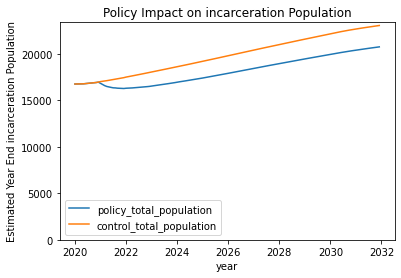

In [7]:
resentencing_dict = {'SCH1/2 possession': (sch1_2_transitions, M1_sentences), 'SCH4 possession': (SCH4_transitions, M4_sentences)}
diversion_dict = {'SCH1/2 possession': 'M1', 'SCH4 possession': 'M4'}

# Policy Option Methods
def resentence_shorten_sentence(crime_type, retroactive=False):
    print(f'shorten_sentence: {1 - resentencing_dict[crime_type][1].compartment_duration.mean() / resentencing_dict[crime_type][0].compartment_duration.mean()}')
    return partial(CompartmentTransitions.apply_reduction,
                   reduction_df = pd.DataFrame({'outflow': ['release'], 
                                                'reduction_size': [1 - resentencing_dict[crime_type][1].compartment_duration.mean() / resentencing_dict[crime_type][0].compartment_duration.mean()],
                                                'affected_fraction': [1]}),
                   reduction_type='*',
                   retroactive=retroactive)

def resentence_diversion(crime_type):
    print(f'resentence-diversion: {1 - (1 - diversion_fractions[diversion_dict[crime_type]])/(1 - diversion_fractions[crime_type])}')
    print(f'old diversion: {diversion_fractions[crime_type]}      new diversion: {diversion_fractions[diversion_dict[crime_type]]}')
    return partial (ShellCompartment.reallocate_outflow,
                    reallocation_fraction = 1 - (1 - diversion_fractions[diversion_dict[crime_type]])/(1 - diversion_fractions[crime_type]),
                    outflow = 'incarceration',
                    new_outflow = 'probation')
                    
                    
def increase_diversion(crime_type):
    print(f"increase diversion: {affected_fraction * (1 - diversion_fractions[crime_type]) * diversion_fractions[crime_type]}")
    return partial (ShellCompartment.reallocate_outflow,
                    reallocation_fraction = affected_fraction * (1 - diversion_fractions[crime_type]) * diversion_fractions[crime_type],
                    outflow = 'incarceration',
                    new_outflow = 'probation')

policy_list_diversion = [
    SparkPolicy(policy_fn=increase_diversion(crime_type),
                spark_compartment='pretrial',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in diversion_fractions
]
policy_list_resentencing = [
    SparkPolicy(policy_fn=resentence_shorten_sentence(crime_type),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in resentencing_dict
] + [
    SparkPolicy(policy_fn=resentence_diversion(crime_type),
                spark_compartment='pretrial',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in diversion_dict
]
    
test_results = test_sim.simulate_policy(policy_list_diversion + policy_list_resentencing, 'incarceration')

In [8]:
simulation_tag = 'VA_HB2303'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)